# Imports

In [120]:
import math
import json
import string
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.feature_selection import chi2
from sklearn.feature_extraction.text import TfidfVectorizer
from data_loader import DataLoader
from collections import defaultdict
from json import JSONEncoder

plt.style.use('ggplot')
sns.set_palette('tab10')

# Load Data

In [2]:
df, _, _ = DataLoader().create_dataframe(preprocess=True, split=True, remove_duplicates=False)
df.head()

100%|██████████| 239073/239073 [00:05<00:00, 41388.18it/s]


,phrase_id,phrase,phrase_clean,sentiment_val,label_id,label
64633,3748,a fairy tale that comes from a renowned indian...,fairy tale comes renowned indian film culture ...,0.88889,5.0,Very positive
23483,183087,Chris Cooper 's,Chris Cooper,0.50000,3.0,Neutral
93051,229624,call it a work of art,call work art,0.76389,4.0,Positive
156735,166035,miss it altogether,miss altogether,0.13889,1.0,Very negative
15507,103745,A muddled limp biscuit,A muddled limp biscuit,0.19444,1.0,Very negative


In [3]:
df.shape

(142410, 6)

# Helper functions

In [4]:
def plot_stats(stats, xlabel, ylabel, title, save_fig=False):
    fig, ax = plt.subplots(figsize = (8,4))
    
    ax = stats.mean().plot(kind='bar', alpha=0.65)
    ax = stats.median().plot(kind='bar', alpha=0.65)
    
    ax.set_xlabel(xlabel)
    ax.set_ylabel(ylabel)
    ax.set_title(title)
    
    plt.legend(['Mean', 'Median'])
    
    if save_fig:
        plt.savefig('mean_med', dpi=300)

# Duplicates

In [109]:
class PhraseCount:
    def __init__(self):
        self.label = ""
        self.count = 0
        
class Encoder(JSONEncoder):
    def default(self, o):
        return o.__dict__
    
phrase_count = defaultdict(PhraseCount)

for p, l in zip(df['phrase_clean'], df['label']):
    phrase_count[p].label = l
    phrase_count[p].count += 1

neutral_counts = []
very_neg_counts = []
neg_counts = []
very_pos_counts = []
pos_counts = []

for k, v in json.loads(Encoder().encode(phrase_count)).items():
    if v['count'] > 1:
        if v['label'] == 'Neutral':
            neutral_counts.append(v['count'])
        if v['label'] == 'Very negative':
            very_neg_counts.append(v['count'])
        if v['label'] == 'Negative':
            neg_counts.append(v['count'])
        if v['label'] == 'Very positive':
            very_pos_counts.append(v['count'])
        if v['label'] == 'Positive':
            pos_counts.append(v['count'])
            

total_neutral = df[df['label'] == 'Neutral'].shape[0]
total_very_neg = df[df['label'] == 'Very negative'].shape[0]
total_neg = df[df['label'] == 'Negative'].shape[0]
total_very_pos = df[df['label'] == 'Very positive'].shape[0]
total_pos = df[df['label'] == 'Positive'].shape[0]

duplicates = [sum(neutral_counts), sum(pos_counts), sum(neg_counts), sum(very_pos_counts), sum(very_neg_counts)]

In [110]:
totals = [total_neutral, total_pos, total_neg, total_very_pos, total_very_neg]
print(totals)

[58746, 25150, 21866, 7876, 5830]


In [111]:
dupls = pd.DataFrame({'Total': totals, 'Duplicate': duplicates})

In [112]:
dupls['Total'].sum(), dupls['Duplicate'].sum()

(119468, 21487)

Text(0.5, 0, 'Sentiment')

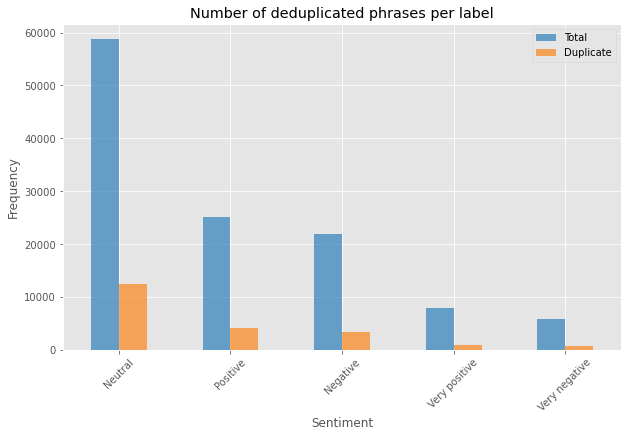

In [113]:
ax = dupls.plot(kind='bar', stacked=False, alpha=0.65, figsize=(10,6))
ax.set_xticklabels(['Neutral', 'Positive', 'Negative', 'Very positive', 'Very negative'], rotation=45)
ax.set_title('Number of deduplicated phrases per label')
ax.set_ylabel('Frequency')
ax.set_xlabel('Sentiment')

#plt.savefig('dupls', dpi=300)

## Tukey's Fences

In [114]:
def tukeys_fences(l, k=1.5):
    q1 = np.percentile(l, 25)
    q3 = np.percentile(l, 75)
    
    lhs = math.ceil(q1 - (k * (q3 - q1)))
    rhs = math.ceil(q1 + (k * (q3 - q1)))
    
    return (lhs, rhs)

In [115]:
tukeys = [neutral_counts, neg_counts, very_neg_counts, pos_counts, very_pos_counts]

for t in tukeys:
    print(tukeys_fences(t))

(-1, 5)
(3, 3)
(3, 3)
(2, 5)
(3, 3)


In [79]:
phrases_to_dedup = []

for k, v in json.loads(Encoder().encode(phrase_count)).items():
        if v['label'] == 'Neutral' and v['count'] > 1 and v['count'] < 4:
            phrases_to_dedup.append(k)
        if v['count'] == 2:
            if v['label'] == 'Very negative' or v['label'] == 'Negative' or v['label'] == 'Very positive' or v['label'] == 'Positive':
                phrases_to_dedup.append(k)

len(phrases_to_dedup)

22942

In [80]:
tst = df[df['phrase_clean'].isin(phrases_to_dedup)]

In [81]:
tst.shape

(48123, 6)

In [82]:
tst = tst.drop_duplicates(subset=['phrase_clean'])

In [85]:
df.shape, tst.shape

((142410, 6), (22942, 6))

In [89]:
df = pd.concat([df, tst]).drop_duplicates(keep=False)

In [108]:
df.shape

(119468, 10)

In [90]:
df.head()

,phrase_id,phrase,phrase_clean,sentiment_val,label_id,label
64633,3748,a fairy tale that comes from a renowned indian...,fairy tale comes renowned indian film culture ...,0.88889,5.0,Very positive
23483,183087,Chris Cooper 's,Chris Cooper,0.50000,3.0,Neutral
93051,229624,call it a work of art,call work art,0.76389,4.0,Positive
15507,103745,A muddled limp biscuit,A muddled limp biscuit,0.19444,1.0,Very negative
84727,115229,ate,ate,0.36111,2.0,Negative


# Label Class Balance

[Text(0, 0, 'Neutral'),
 Text(1, 0, 'Positive'),
 Text(2, 0, 'Negative'),
 Text(3, 0, 'Very positive'),
 Text(4, 0, 'Very negative')]

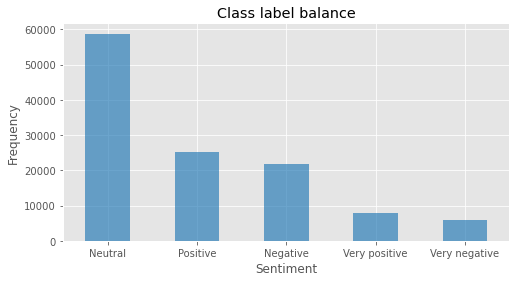

In [92]:
fig, ax = plt.subplots(figsize = (8,4))
ax = df['label'].sort_values(ascending=False).value_counts().plot(kind='bar', alpha=0.65)
ax.set_xlabel('Sentiment')
ax.set_ylabel('Frequency')
ax.set_title('Class label balance')

ax.set_xticklabels(['Neutral', 'Positive', 'Negative', 'Very positive', 'Very negative'], rotation=0)

# Word Count

In [93]:
df['word_count'] = df['phrase_clean'].apply(lambda x: len(str(x).split()))

word_stats = df.groupby('label')['word_count']
word_stats.describe()

,count,mean,std,min,25%,50%,75%,max
label,,,,,,,,
Negative,21866.0,5.705936,4.485264,1.0,2.0,4.0,8.0,30.0
Neutral,58746.0,3.299510,3.204758,1.0,1.0,2.0,4.0,28.0
Positive,25150.0,5.255586,4.344352,1.0,2.0,4.0,7.0,29.0
Very negative,5830.0,7.416638,4.991999,1.0,3.0,6.0,10.0,30.0
Very positive,7876.0,6.754063,4.813191,1.0,3.0,5.0,9.0,28.0


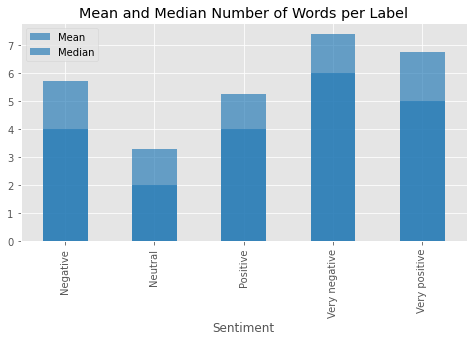

In [94]:
plot_stats(word_stats, xlabel='Sentiment', ylabel='', title='Mean and Median Number of Words per Label')

# Punctuation Count

In [95]:
df['punct_count'] = df['phrase'].apply(lambda x: len("".join(_ for _ in x if _ in string.punctuation)))

In [96]:
punct_stats = df.groupby('label')['punct_count']
punct_stats.describe()

,count,mean,std,min,25%,50%,75%,max
label,,,,,,,,
Negative,21866.0,1.395134,1.913808,0.0,0.0,1.0,2.0,21.0
Neutral,58746.0,0.735642,1.363561,0.0,0.0,0.0,1.0,23.0
Positive,25150.0,1.204334,1.745929,0.0,0.0,1.0,2.0,17.0
Very negative,5830.0,2.014580,2.305600,0.0,0.0,1.0,3.0,22.0
Very positive,7876.0,1.639538,1.989804,0.0,0.0,1.0,2.0,18.0


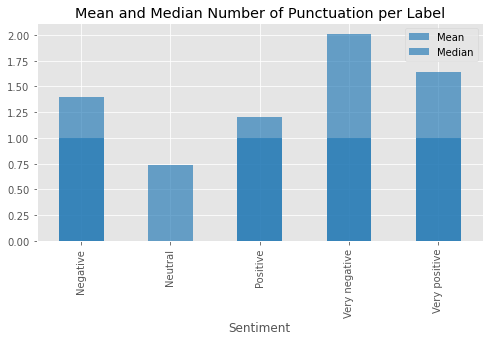

In [97]:
plot_stats(punct_stats, xlabel='Sentiment', ylabel='', title='Mean and Median Number of Punctuation per Label')

- Punctuation occurs more often in in the extreme sentiments.
- Could be a good feature to include in classification to discriminate classes from each other.

# Upper case letter count

In [98]:
df['num_caps'] = df['phrase_clean'].apply(lambda x: sum(1 for c in x if c.isupper()))

In [99]:
numcap_stats = df.groupby('label')['punct_count']
numcap_stats.describe()

,count,mean,std,min,25%,50%,75%,max
label,,,,,,,,
Negative,21866.0,1.395134,1.913808,0.0,0.0,1.0,2.0,21.0
Neutral,58746.0,0.735642,1.363561,0.0,0.0,0.0,1.0,23.0
Positive,25150.0,1.204334,1.745929,0.0,0.0,1.0,2.0,17.0
Very negative,5830.0,2.014580,2.305600,0.0,0.0,1.0,3.0,22.0
Very positive,7876.0,1.639538,1.989804,0.0,0.0,1.0,2.0,18.0


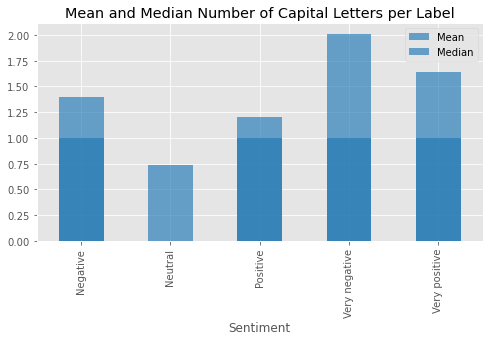

In [100]:
plot_stats(numcap_stats, xlabel='Sentiment', ylabel='', title='Mean and Median Number of Capital Letters per Label')

- Capital letters occur more often in in the extreme sentiments.
- Could be a good feature to include in classification to discriminate classes from each other, as well.

# Number of adjective POS tags

In [101]:
from helpers import pos_check

In [102]:
df['adj_count'] = df['phrase_clean'].apply(lambda x: pos_check(x))

In [103]:
df.head()

,phrase_id,phrase,phrase_clean,sentiment_val,label_id,label,word_count,punct_count,num_caps,adj_count
64633,3748,a fairy tale that comes from a renowned indian...,fairy tale comes renowned indian film culture ...,0.88889,5.0,Very positive,12,0,0,3
23483,183087,Chris Cooper 's,Chris Cooper,0.50000,3.0,Neutral,2,1,2,0
93051,229624,call it a work of art,call work art,0.76389,4.0,Positive,3,0,0,0
15507,103745,A muddled limp biscuit,A muddled limp biscuit,0.19444,1.0,Very negative,4,0,1,1
84727,115229,ate,ate,0.36111,2.0,Negative,1,0,0,0


# Density plot of above stats

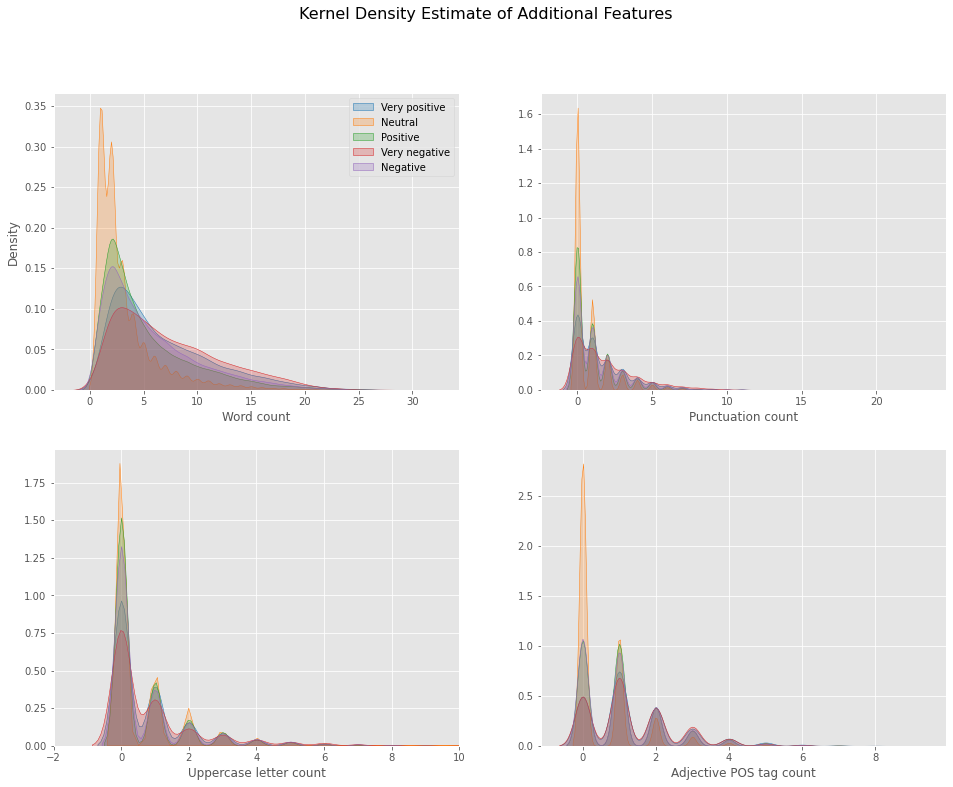

In [105]:
fig, ax = plt.subplots(nrows=2, ncols=2, figsize=(16, 12))
fig.suptitle('Kernel Density Estimate of Additional Features', fontsize=16)

labels = df['label'].unique()

for i in labels:
    sns.kdeplot(df[df['label'] == i]['word_count'], ax=ax[0][0], shade=True)
    sns.kdeplot(df[df['label'] == i]['punct_count'], ax=ax[0][1], shade=True)
    sns.kdeplot(df[df['label'] == i]['num_caps'], ax=ax[1][0], shade=True)
    sns.kdeplot(df[df['label'] == i]['adj_count'], ax=ax[1][1], shade=True)

ax[0][0].legend(df['label'].unique())
ax[0][0].set_xlabel('Word count')
ax[0][0].set_ylabel('Density')

ax[0][1].set_xlabel('Punctuation count')
ax[0][1].set_ylabel('')

ax[1][0].set_xlim(-2, 10)
ax[1][0].set_xlabel('Uppercase letter count')
ax[1][0].set_ylabel('')

ax[1][1].set_xlabel('Adjective POS tag count')
ax[1][1].set_ylabel('')

plt.savefig('kde')

# Chi2 Features

In [117]:
train, _, _ = DataLoader().create_dataframe(preprocess=True, split=True, remove_duplicates=True)

100%|██████████| 239073/239073 [00:05<00:00, 42577.71it/s]


In [121]:
X_train, y_train = train['phrase_clean'], train['label_id']

In [122]:
tfidf_vect = TfidfVectorizer(analyzer='word', 
                             max_features=10000, 
                             use_idf=True, 
                             ngram_range=(1,3))

In [123]:
X_train_tfidf = tfidf_vect.fit_transform(X_train)
chi2score = chi2(X_train_tfidf, y_train)[0]

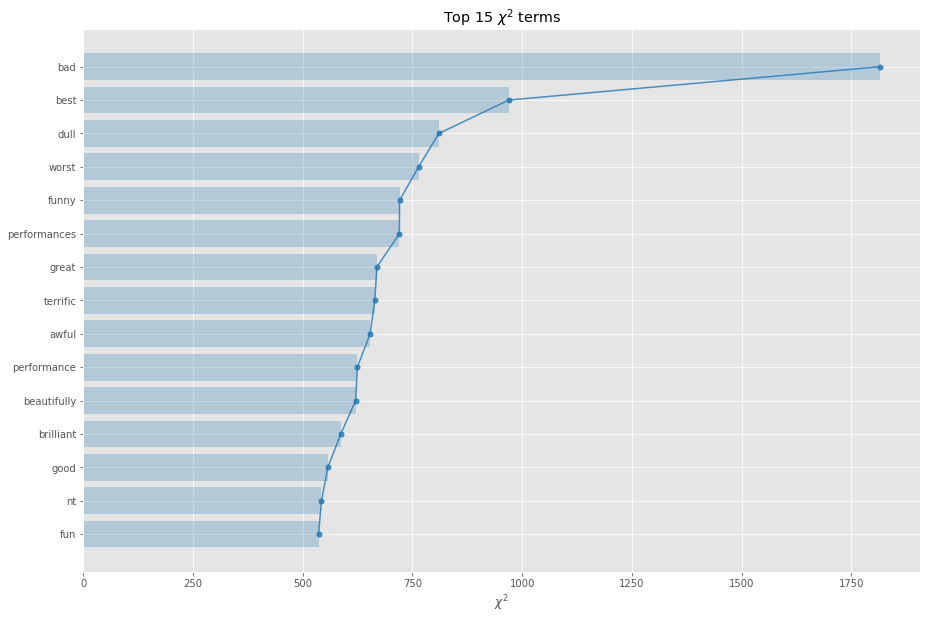

In [132]:
plt.figure(figsize=(15,10))
wscores = zip(tfidf_vect.get_feature_names(), chi2score)
wchi2 = sorted(wscores, key=lambda x:x[1])
topchi2 = list(zip(*wchi2[-15:]))
x = range(len(topchi2[1]))
labels = topchi2[0]
plt.barh(x,topchi2[1], align='center', alpha=0.25)
plt.plot(topchi2[1], x, '-o', markersize=5, alpha=0.8)
plt.yticks(x, labels)
plt.xlabel('$\chi^2$')

plt.title('Top 15 $\chi^2$ terms')

plt.savefig('x2', dpi=300)